<a href="https://colab.research.google.com/github/shenzhun/machine-learning-prep/blob/master/tensorflow/day7_high_level_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preparation

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import models,layers,losses,metrics,optimizers

# Number of sample
n = 400

# Generating the datasets
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0) 

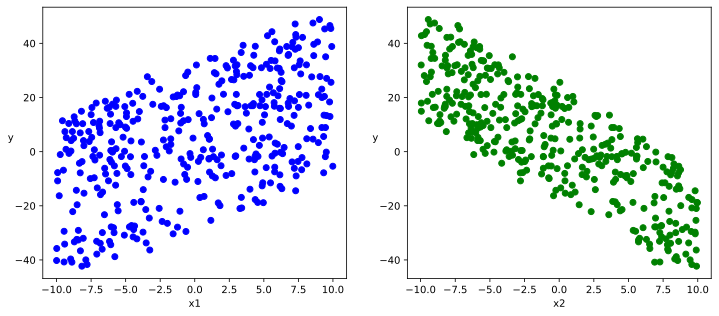

In [2]:
# Data Visualization

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [3]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(1, input_shape=(2,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X, Y, batch_size=50, epochs=200)

tf.print("w = ", model.layers[0].kernel)
tf.print("b = ", model.layers[0].bias)

Epoch 1/200
8/8 [==============================] - 0s 2ms/step - loss: 3.5749 - mae: 1.4980
Epoch 2/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5732 - mae: 1.4976
Epoch 3/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5735 - mae: 1.4976
Epoch 4/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5732 - mae: 1.4976
Epoch 5/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5729 - mae: 1.4975
Epoch 6/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5728 - mae: 1.4975
Epoch 7/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5726 - mae: 1.4975
Epoch 8/200
8/8 [==============================] - 0s 1ms/step - loss: 3.5727 - mae: 1.4975
Epoch 9/200
8/8 [==============================] - 0s 963us/step - loss: 3.5731 - mae: 1.4976
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 3.5738 - mae: 1.4979
Epoch 11/200
8/8 [==============================] - 0s 1ms/step - loss: 3.572

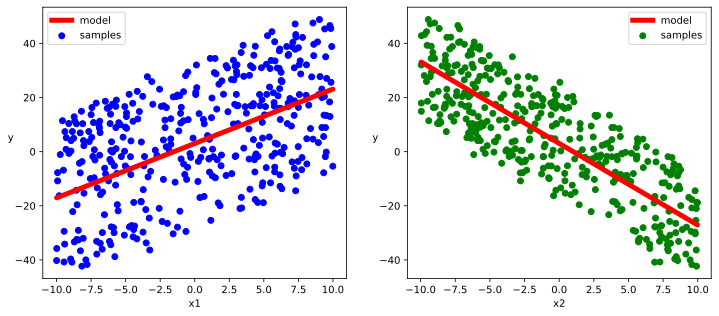

In [6]:
# Visualizing the results

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

DNN Binary Classification Model

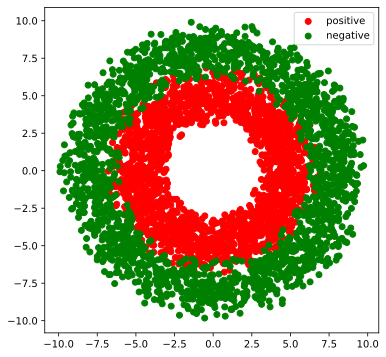

In [7]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Number of the positive/negative samples
n_positive,n_negative = 2000,2000

# Generating the positive samples with a distribution on a smaller ring
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

# Generating the negative samples with a distribution on a larger ring
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

# Assembling all samples
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)

# Shuffling the samples
data = tf.concat([X,Y],axis = 1)
data = tf.random.shuffle(data)
X = data[:,:2]
Y = data[:,2:]

# Visualizing the data
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [8]:
ds_train = tf.data.Dataset.from_tensor_slices((X[0:n*3//4,:],Y[0:n*3//4,:])) \
     .shuffle(buffer_size = 1000).batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

In [11]:
tf.keras.backend.clear_session()

class DNNModel(models.Model):
  def __init__(self):
    super(DNNModel, self).__init__()

  def build(self, input_shape):
    self.dense1 = layers.Dense(4, activation="relu", name="dense1")
    self.dense2 = layers.Dense(8, activation="relu", name="dense2")
    self.dense3 = layers.Dense(1, activation="sigmoid", name="dense3")
    super(DNNModel, self).build(input_shape)
  
  #forward propagation
  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
  def call(self, x):
    x = self.dense1(x)
    x = self.dense2(x)
    y = self.dense3(x)
    return y
  
model = DNNModel()
model.build(input_shape=(None, 2))

model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  12        
_________________________________________________________________
dense2 (Dense)               multiple                  40        
_________________________________________________________________
dense3 (Dense)               multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_metric = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')

@tf.function
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    predications = model(features)
    loss = loss_func(labels, predications)
  
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss.update_state(loss)
  train_metric.update_state(labels, predications)

@tf.function
def valid_step(model, features, labels):
  predications = model(features)
  batch_loss = loss_func(labels, predications)
  valid_loss.update_state(batch_loss)
  valid_metric.update_state(labels, predications)

def train_model(model, ds_train, ds_valid, epochs):
  for epoch in tf.range(1, epochs+1):
    for features, labels in ds_train:
      train_step(model, features, labels)
    
    for features, labels in ds_valid:
      valid_step(model, features, labels)
    
    logs = 'Epoch={},Loss={},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'

    if epoch % 100 == 0:
      tf.print(tf.strings.format(
          logs, 
          (epoch, train_loss.result(), 
           train_metric.result(), valid_loss.result(),
           valid_metric.result())
      ))
    
    train_loss.reset_states()
    valid_loss.reset_states()
    train_metric.reset_states()
    valid_metric.reset_states()

train_model(model, ds_train, ds_valid, 1000)


Epoch=100,Loss=0.0776530728,Accuracy:0.966666639,Valid Loss:0.152235389,Valid Accuracy:0.935945928
Epoch=200,Loss=0.070805043,Accuracy:0.97,Valid Loss:0.15981631,Valid Accuracy:0.937027037
Epoch=300,Loss=0.0686652511,Accuracy:0.966666639,Valid Loss:0.166910216,Valid Accuracy:0.938918948
Epoch=400,Loss=0.0682383,Accuracy:0.966666639,Valid Loss:0.166928545,Valid Accuracy:0.93972975
Epoch=500,Loss=0.067891,Accuracy:0.97,Valid Loss:0.17461127,Valid Accuracy:0.938108087
Epoch=600,Loss=0.0667413846,Accuracy:0.966666639,Valid Loss:0.17172052,Valid Accuracy:0.938918948
Epoch=700,Loss=0.0666108876,Accuracy:0.97,Valid Loss:0.173968792,Valid Accuracy:0.939459443
Epoch=800,Loss=0.0663177446,Accuracy:0.97,Valid Loss:0.177213177,Valid Accuracy:0.938918948
Epoch=900,Loss=0.0643674,Accuracy:0.97,Valid Loss:0.175590605,Valid Accuracy:0.940270245
Epoch=1000,Loss=0.0641435534,Accuracy:0.97,Valid Loss:0.176603243,Valid Accuracy:0.941081107


Text(0.5, 1.0, 'y_pred')

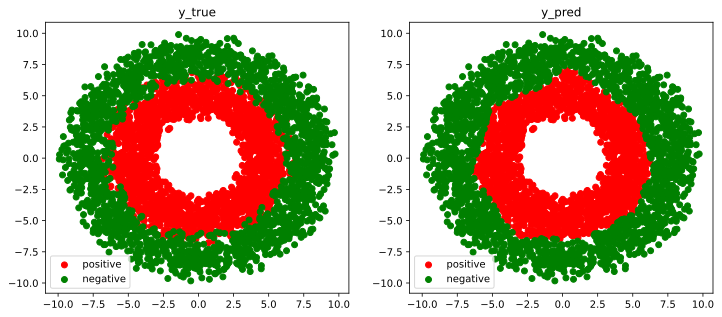

In [14]:
# Visualizing the results
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")